In [1]:
import lightkurve as lk
%matplotlib inline
import starry
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import pymc3 as pm
import pymc3_ext as pmx
import theano.tensor as tt
import exoplanet as xo

In [2]:
starry.config.lazy = False
starry.config.quiet = True

In [3]:
star = starry.Primary(starry.Map(ydeg=0, udeg=2, amp=1.0), m=0.809, r=0.683)

In [4]:
star.map[1] = 0.646 # limb-darkening coefficient
star.map[2] = 0.048

In [5]:
search_result = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='short')
# Download all available Kepler light curves
lc_collection = search_result.download_all()
# lc_collection.plot();

In [63]:
search_result1 = lk.search_lightcurve('HAT-P-11', author='Kepler', cadence='long')
# Download all available Kepler light curves
lc_collection1 = search_result1.download_all()
# lc_collection.plot();

In [64]:
search_result.year

array([2009, 2009, 2009, 2009, 2009, 2009, 2009, 2009, 2010, 2010, 2010,
       2010, 2010, 2010, 2010, 2010, 2010, 2011, 2011, 2011, 2011, 2011,
       2011, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2012, 2013,
       2013, 2013, 2013, 2013])

In [65]:
search_result1.year

array([2009, 2009, 2009, 2009, 2010, 2010, 2010, 2011, 2011, 2011, 2012,
       2012, 2012, 2013, 2013])

In [71]:
lc1 = search_result[search_result.year == 2009].download_all()
lc3 = search_result[search_result.year == 2010].download_all()
lc4 = search_result[search_result.year == 2012].download_all()
lc2 = search_result[search_result.year == 2010].download_all() 

In [72]:
lc1 = lc1.stitch()
lc3 = lc3.stitch()
lc4 = lc4.stitch()
lc2 = lc2.stitch()

In [73]:
lc2.head()

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
413.2993275112749,1.0030191e+00,8.4737723e-05,0,-1.525029e-03,551.77573,821.46237,435340,2.7362382e+06,2.2766580e+02,9.8445010e+03,2.6490915e+00,2.7336262e+06,2.3094403e+02,0,———,———,———,———,551.77573,6.7734181e-05,821.46237,2.2456255e-04,-1.3840208e-02,-4.7592893e-02
413.30000861278677,1.0030589e+00,8.4738997e-05,0,-1.525027e-03,551.77539,821.46288,435341,2.7363462e+06,2.2767233e+02,9.8445996e+03,2.6491086e+00,2.7337348e+06,2.3094749e+02,0,———,———,———,———,551.77539,6.7724715e-05,821.46288,2.2455018e-04,-1.3846081e-02,-4.7589939e-02
413.3006897141822,1.0030962e+00,8.4738029e-05,0,-1.525026e-03,551.77472,821.46167,435342,2.7364478e+06,2.2767294e+02,9.8446982e+03,2.6491258e+00,2.7338365e+06,2.3094485e+02,0,———,———,———,———,551.77472,6.7724875e-05,821.46167,2.2443196e-04,-1.3851953e-02,-4.7586981e-02
413.30137091570214,1.0032344e+00,8.4742227e-05,0,-1.525024e-03,551.77466,821.46224,435343,2.7368235e+06,2.2768810e+02,9.8447969e+03,2.6491430e+00,2.7342130e+06,2.3095630e+02,0,———,———,———,———,551.77466,6.7716283e-05,821.46224,2.2442367e-04,-1.3857827e-02,-4.7584023e-02
413.302052017214,1.0029976e+00,8.4732601e-05,10000000000000,-1.525023e-03,551.77503,821.46208,435344,2.7361800e+06,2.2766541e+02,9.8448945e+03,2.6491601e+00,2.7335678e+06,2.3093007e+02,10000000000000,———,———,———,———,551.77503,6.7730653e-05,821.46208,2.2447405e-04,-1.3863700e-02,-4.7581065e-02


In [74]:
lc1['time']

<Time object: scale='tdb' format='bkjd' value=[120.52859841 120.52927953 120.52996076 ... 349.50475254 349.50543371
 349.50611479]>

In [75]:
lc1['time'].format = 'iso'
lc3['time'].format = 'iso'
lc4['time'].format = 'iso'
lc2['time'].format = 'iso'

In [77]:
lc1.tail()

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2009-12-17 00:04:52.929,1.0030860e+00,8.7367946e-05,0,-3.595564e-04,552.16784,816.86224,341675,2.8875612e+06,2.4201497e+02,6.5285693e+03,2.7677212e+00,2.9114090e+06,2.5358130e+02,0,———,———,———,———,552.16784,7.5604752e-05,816.86224,2.2205619e-04,1.4176921e-03,2.6190327e-02
2009-12-17 00:05:51.774,1.0031037e+00,8.7396955e-05,0,-3.595806e-04,552.16810,816.86110,341676,2.8875545e+06,2.4201660e+02,6.5289941e+03,2.7677925e+00,2.9114608e+06,2.5366548e+02,0,———,———,———,———,552.16810,7.5573349e-05,816.86110,2.2211265e-04,1.4145803e-03,2.6193406e-02
2009-12-17 00:06:50.619,1.0027026e+00,8.7411841e-05,0,-3.596049e-04,552.16918,816.86196,341677,2.8863402e+06,2.4196829e+02,6.5294180e+03,2.7678638e+00,2.9102965e+06,2.5370869e+02,0,———,———,———,———,552.16918,7.5603872e-05,816.86196,2.2207269e-04,1.4114685e-03,2.6196485e-02
2009-12-17 00:07:49.473,1.0031241e+00,8.7460110e-05,0,-3.596292e-04,552.16934,816.86214,341678,2.8874898e+06,2.4201254e+02,6.5298423e+03,2.7679350e+00,2.9115200e+06,2.5384880e+02,0,———,———,———,———,552.16934,7.5579759e-05,816.86214,2.2210415e-04,1.4083562e-03,2.6199566e-02
2009-12-17 00:08:48.318,1.0031514e+00,8.7496548e-05,0,-3.596535e-04,552.16892,816.86241,341679,2.8875022e+06,2.4201241e+02,6.5302671e+03,2.7680063e+00,2.9115990e+06,2.5395454e+02,0,———,———,———,———,552.16892,7.5575284e-05,816.86241,2.2209880e-04,1.4052445e-03,2.6202645e-02


In [13]:
lc1['time'].value[-1].split('-')[2].split(' ')[0]

'17'

In [14]:
lc1['time'].value[-1].split('-')[1]

'12'

In [15]:
mask3 = [i.split('-')[1]=='04' and i.split('-')[2].split(' ')[0]=='18' for i in lc3['time'].value]
mask1 = [i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='02' for i in lc1['time'].value]
mask2 = [i.split('-')[1]=='12' and i.split('-')[2].split(' ')[0]=='31' for i in lc1['time'].value]
mask4 = [i.split('-')[1]=='01' and i.split('-')[2].split(' ')[0]=='08' for i in lc4['time'].value]

In [16]:
lc2 = lc1[mask2]
lc1 = lc1[mask1]
lc3 = lc3[mask3]
lc4 = lc4[mask4]

In [17]:
lc1.head()

time,flux,flux_err,quality,timecorr,centroid_col,centroid_row,cadenceno,sap_flux,sap_flux_err,sap_bkg,sap_bkg_err,pdcsap_flux,pdcsap_flux_err,sap_quality,psf_centr1,psf_centr1_err,psf_centr2,psf_centr2_err,mom_centr1,mom_centr1_err,mom_centr2,mom_centr2_err,pos_corr1,pos_corr2
,,,,d,pix,pix,,electron / s,electron / s,electron / s,electron / s,electron / s,electron / s,,pix,pix,pix,pix,pix,pix,pix,pix,pix,pix
Time,float32,float32,int32,float32,float64,float64,int32,float32,float32,float32,float32,float32,float32,int32,float64,float32,float64,float32,float64,float32,float64,float32,float32,float32
2009-12-02 00:00:21.455,9.8860931e-01,8.4487605e-05,0,2.075830e-04,552.16583,816.84150,319647,2.8440892e+06,2.4030913e+02,6.1280581e+03,2.7607636e+00,2.8693912e+06,2.4522124e+02,0,———,———,———,———,552.16583,7.6353346e-05,816.84150,2.2165503e-04,-2.5002537e-06,-3.8536750e-03
2009-12-02 00:01:20.300,9.8858190e-01,8.4487743e-05,0,2.075561e-04,552.16663,816.84228,319648,2.8440160e+06,2.4031375e+02,6.1276704e+03,2.7608359e+00,2.8693118e+06,2.4522165e+02,0,———,———,———,———,552.16663,7.6358258e-05,816.84228,2.2167957e-04,-2.2290669e-07,-3.8574166e-03
2009-12-02 00:02:19.145,9.8865736e-01,8.4489919e-05,0,2.075293e-04,552.16590,816.84125,319649,2.8442362e+06,2.4032524e+02,6.1272822e+03,2.7609084e+00,2.8695308e+06,2.4522795e+02,0,———,———,———,———,552.16590,7.6366734e-05,816.84125,2.2169418e-04,2.0544403e-06,-3.8611582e-03
2009-12-02 00:03:17.989,9.8848975e-01,8.4479332e-05,0,2.075023e-04,552.16653,816.84198,319650,2.8437555e+06,2.4030035e+02,6.1268945e+03,2.7609811e+00,2.8690442e+06,2.4519722e+02,0,———,———,———,———,552.16653,7.6352408e-05,816.84198,2.2166816e-04,4.3317868e-06,-3.8648997e-03
2009-12-02 00:04:16.834,9.8855036e-01,8.4482606e-05,0,2.074754e-04,552.16671,816.84153,319651,2.8439295e+06,2.4031659e+02,6.1265068e+03,2.7610533e+00,2.8692202e+06,2.4520674e+02,0,———,———,———,———,552.16671,7.6372889e-05,816.84153,2.2168983e-04,6.6091338e-06,-3.8686413e-03


In [18]:
lc1['time'].format = 'bkjd'
lc2['time'].format = 'bkjd'
lc3['time'].format = 'bkjd'
lc4['time'].format = 'bkjd'

In [19]:
lc1['time']

<Time object: scale='tdb' format='bkjd' value=[334.50024832 334.5009294  334.50161047 ... 335.49804959 335.49873077
 335.49941184]>

In [20]:
pg4 = lc4.to_periodogram(minimum_period = 4.08,
                      maximum_period = 5,
                      oversample_factor=100)
pg3 = lc3.to_periodogram(minimum_period = 4.2,
                      maximum_period = 5,
                      oversample_factor=100)
pg1 = lc1.to_periodogram(minimum_period = 4.2,
                      maximum_period = 5,
                      oversample_factor=100)

<AxesSubplot:xlabel='Period [$\\mathrm{d}$]', ylabel='Power'>

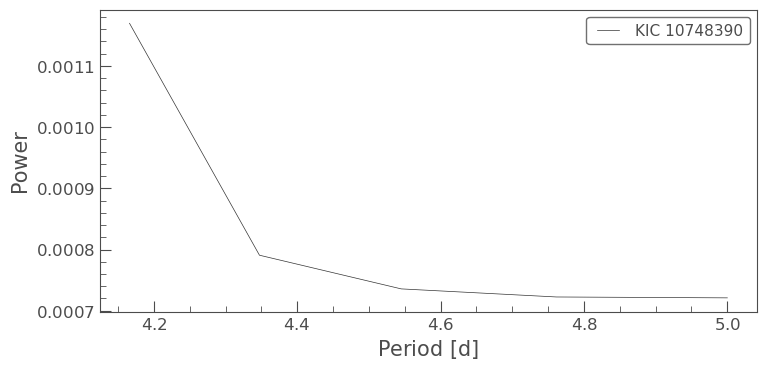

In [21]:
pg4.plot()

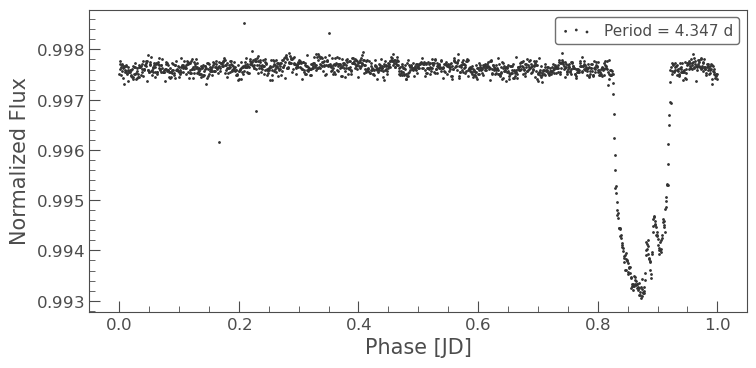

In [22]:
period4 = pg4.period_at_max_power
period3 = pg3.period_at_max_power
period1 = pg1.period_at_max_power
lc4.fold(period4).scatter(label=rf'Period = {period1.value:.3f} d');

In [23]:
pg4.frequency_at_max_power

<Quantity 0.24003317 1 / d>

In [56]:
planet4 = starry.kepler.Secondary(
    starry.Map(udeg=2),  # the surface map
    m=7.0257708e-5,  # mass in solar masses
    r=0.039974684,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=period4,  # orbital period in days
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    # t0=0.5,  # time of transit in days
)

planet3 = starry.kepler.Secondary(
    starry.Map(udeg=2),  # the surface map
    m=7.0257708e-5,  # mass in solar masses
    r=0.039974684,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=4.888,  # orbital period in days
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    # t0=0.5,  # time of transit in days
)

planet1 = starry.kepler.Secondary(
    starry.Map(udeg=2),  # the surface map
    m=7.0257708e-5,  # mass in solar masses
    r=0.039974684,  # radius in solar radii
    inc=88.99, # orbital inclination
    porb=period1,  # orbital period in days
    w=-162.149,  # Argument of periastron (little omega)
    ecc=0.265,  # eccentricity
    Omega=106, # I think it's lambda in Morris 2017
    # t0=0.5,  # time of transit in days
)

In [57]:
period = np.linspace(4.8, 5, 10000)
# Create a BLSPeriodogram
bls4 = lc4.to_periodogram(method='bls', period=period, frequency_factor=500);
bls3 = lc3.to_periodogram(method='bls', period=period, frequency_factor=500);
bls1 = lc1.to_periodogram(method='bls', period=period, frequency_factor=500);

In [58]:
bls3.period_at_max_power

<Quantity 4.8 d>

In [59]:
system4 = starry.System(star, planet4)
time4 = lc4.normalize().fold(period=period4, epoch_time=bls4.transit_time_at_max_power)['time'].value

system3 = starry.System(star, planet3)
time3 = lc3.normalize().fold(period=period3, epoch_time=bls3.transit_time_at_max_power)['time'].value

system1 = starry.System(star, planet1)
time1 = lc1.normalize().fold(period=period1, epoch_time=bls1.transit_time_at_max_power)['time'].value

In [60]:
time4

array([-0.875     , -0.87431882, -0.87363774, ...,  0.12280908,
        0.12349025,  0.12417133])

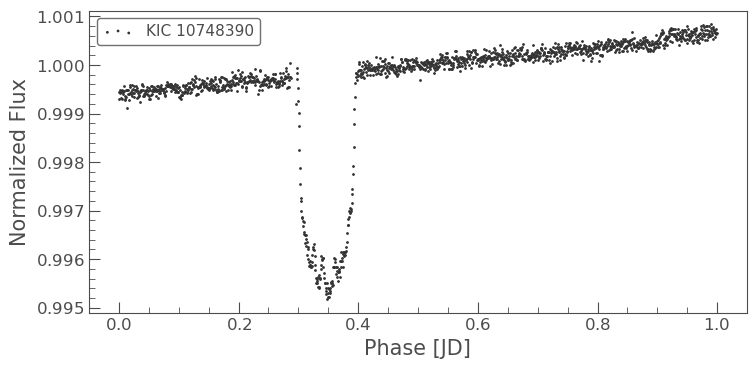

In [61]:
ax = lc3.normalize().fold(period=period3).scatter()
# plt.plot(time3, flux_star3)

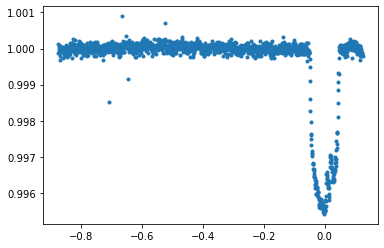

In [29]:
plt.plot(time4,
    lc4.normalize().fold(period=period4)['flux'],'.')

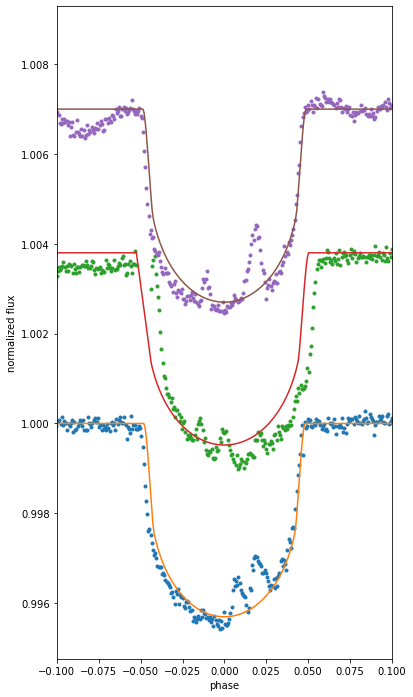

In [62]:
flux_star4, flux_planet4 = system4.flux(time4, total=False)
flux_star3, flux_planet3 = system3.flux(time3, total=False)
flux_star1, flux_planet1 = system1.flux(time1, total=False)

fig = plt.subplots(figsize=(6, 12), sharex=True)

# lc4.normalize().fold(period=period4, epoch_time=bls4.transit_time_at_max_power).scatter()
plt.plot(time4,(lc4.normalize().fold(period=period4, epoch_time=bls4.transit_time_at_max_power).flux),'.')
plt.plot(time4, flux_star4)

# (lc3.normalize().fold(period=period3, epoch_time=bls3.transit_time_at_max_power)+0.004).scatter()
plt.plot(time3,(lc3.normalize().fold(period=period3, epoch_time=bls3.transit_time_at_max_power).flux+0.0038),'.')
plt.plot(time3, flux_star3+0.0038)

# (lc1.normalize().fold(period=period1, epoch_time=bls1.transit_time_at_max_power)+0.008).scatter()
plt.plot(time1,(lc1.normalize().fold(period=period1, epoch_time=bls1.transit_time_at_max_power).flux+0.007),'.')
plt.plot(time1, flux_star1+0.007)

plt.xlim(-0.1,0.1)
plt.xlabel("phase")
plt.ylabel("normalized flux");
plt.show()